<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据量" data-toc-modified-id="数据量-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据量</a></span></li><li><span><a href="#预处理与生成辅助文件" data-toc-modified-id="预处理与生成辅助文件-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>预处理与生成辅助文件</a></span></li><li><span><a href="#训练集和测试集" data-toc-modified-id="训练集和测试集-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>训练集和测试集</a></span></li><li><span><a href="#标的数据" data-toc-modified-id="标的数据-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>标的数据</a></span></li><li><span><a href="#用户基本信息数据" data-toc-modified-id="用户基本信息数据-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>用户基本信息数据</a></span></li><li><span><a href="#用户画像" data-toc-modified-id="用户画像-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>用户画像</a></span></li><li><span><a href="#用户行为日志" data-toc-modified-id="用户行为日志-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>用户行为日志</a></span></li><li><span><a href="#用户借款日志" data-toc-modified-id="用户借款日志-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>用户借款日志</a></span></li></ul></div>

In [17]:
from functions import *

In [157]:
from config import *
from functions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import json
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

# 数据量

In [2]:
## 各个文件数据量
str_names = ['test', 'train', 'listing_info', 'user_info', 'user_behavior_logs', 'user_taglist', 'user_repay_logs']
for name in str_names:
    locals()['df_'+name] = pd.read_csv(path_data+locals()['file_'+name])
    print(name, locals()['df_'+name].shape)

test (130000, 5)
train (1000000, 7)
listing_info (5484891, 6)
user_info (954209, 8)
user_behavior_logs (55781271, 3)
user_taglist (615160, 3)
user_repay_logs (18001297, 7)


# 预处理与生成辅助文件

In [20]:
# 训练集预处理
df_train = df_train.sort_values(by=['user_id', 'listing_id', 'auditing_date', 'repay_date']) # 按照(用户 标的 成交日期 还款日期排序)
df_train.replace({r'\N':np.nan}, inplace=True) # 缺失值处理
df_train['repay_interval'] = df_train['due_date'] + ':' + df_train['repay_date']
df_train['repay_interval'] = df_train['repay_interval'].apply(get_repay_interval) # 计算还款日期举例最晚还款日的间隔
df_train['is_repay'] = df_train['repay_date'].apply(lambda x: 0 if x is np.nan else 1) # 是否逾期

In [35]:
# 生成文件：训练集标的信息
df_listing_info_train = df_listing_info[df_listing_info.listing_id.isin(df_train.listing_id.unique())].copy()
df_listing_info_train.to_csv(path_data+file_listing_info_train, index=None)

# 生成文件：测试集标的信息
df_listing_info_test = df_listing_info[df_listing_info.listing_id.isin(df_test.listing_id.unique())].copy()
df_listing_info_test.to_csv(path_data+file_listing_info_test, index=None)

In [37]:
# 生成文件：训练集用户日志信息
df_user_repay_logs_train = df_user_repay_logs[df_user_repay_logs.user_id.isin(df_train.user_id.unique())].copy()
df_user_repay_logs_train.to_csv(path_data+file_user_repay_logs_train, index=None)

# 生成文件：测试集用户日志信息
df_user_repay_logs_test = df_user_repay_logs[df_user_repay_logs.user_id.isin(df_test.user_id.unique())].copy()
df_user_repay_logs_test.to_csv(path_data+file_user_repay_logs_test, index=None)

In [7]:
# 生成文件：用户最后一次修改后的基本信息
df_user_info_last_update = df_user_info[['user_id', 'insertdate']]
df_user_info_last_update['insertdate'] = df_user_info_last_update['insertdate'].apply(get_time_string)
df_user_info_last_update = df_user_info_last_update.groupby('user_id').agg(lambda x:':'.join(x)).reset_index()
df_user_info_last_update['insertdate'] = df_user_info_last_update['insertdate'].apply(get_max_time)
df_user_info['insertdate'] = df_user_info['insertdate'].apply(get_time_string)
df_user_info_last_date = pd.merge(df_user_info_last_update, df_user_info, how='left', on=['user_id', 'insertdate'])
df_user_info_last_date.to_csv(path_data + file_user_info_last_date, index=None)

In [44]:
# 生成文件：训练集用户信息
df_user_info_train = df_user_info_last_date[df_user_info_last_date.user_id.isin(df_train.user_id.unique())].copy()
df_user_info_train.to_csv(path_data+file_user_info_train, index=None)

# 生成文件：测试集用户信息
df_user_info_test = df_user_info_last_date[df_user_info_last_date.user_id.isin(df_test.user_id.unique())].copy()
df_user_info_test.to_csv(path_data+file_user_info_test, index=None)

In [137]:
# 生成文件：用户最新的用户画像
df_user_taglist_last_update = df_user_taglist[['user_id', 'insertdate']]
df_user_taglist_last_update['insertdate'] = df_user_taglist_last_update['insertdate'].apply(get_time_string)
df_user_taglist_last_update = df_user_taglist_last_update.groupby('user_id').agg(lambda x:':'.join(x)).reset_index()
df_user_taglist_last_update['insertdate'] = df_user_taglist_last_update['insertdate'].apply(get_max_time)
df_user_taglist['insertdate'] = df_user_taglist['insertdate'].apply(get_time_string)
df_user_taglist_last_date = pd.merge(df_user_taglist_last_update, df_user_taglist, how='left', on=['user_id', 'insertdate'])
df_user_taglist_last_date.to_csv(path_data + file_user_taglist_last_date, index=None)

In [158]:
# 保存tags
taglist = (set(x.split('|')) for x in df_user_taglist_last_date.taglist)
tags = sorted(set.union(*taglist))
with open(path_data+file_tags, 'w') as f:
    json.dump(tags, f)

# 训练集和测试集

In [15]:
# 用户的重合率
num_train_user_id = len(df_train.user_id.unique())
num_test_user_id = len(df_test.user_id.unique())
num_user_info_user_id = len(df_user_info.user_id.unique())
num_user_behavior_logs_user_id = len(df_user_behavior_logs.user_id.unique())
num_user_taglist_user_id = len(df_user_taglist.user_id.unique())
num_user_repay_logs_user_id = len(df_user_repay_logs.user_id.unique())
print('train', num_train_user_id) # 训练集有一个user有很多标的
print('test', num_test_user_id) # 测试集user都只有一个标的
print('user_info', num_user_info_user_id)
print('user_behavior_logs', num_user_behavior_logs_user_id)
print('user_taglist', num_user_taglist_user_id)
print('user_repay_logs', num_user_repay_logs_user_id)

train 823732
test 130000
user_info 928195
user_behavior_logs 920161
user_taglist 535380
user_repay_logs 874841


In [163]:
num_train_test_user_id = len(set(df_train.user_id.unique()) & set(df_test.user_id.unique()))
num_train_user_info_user_id = len(set(df_train.user_id.unique()) & set(df_user_info.user_id.unique()))
num_test_user_info_user_id = len(set(df_test.user_id.unique()) & set(df_user_info.user_id.unique()))
num_user_info_user_behavior_logs_user_id = len(set(df_user_behavior_logs.user_id.unique()) & set(df_user_info.user_id.unique()))
num_user_info_user_taglist_user_id = len(set(df_user_taglist.user_id.unique()) & set(df_user_info.user_id.unique()))
num_user_info_user_repay_logs_user_id = len(set(df_user_repay_logs.user_id.unique()) & set(df_user_info.user_id.unique()))
num_train_user_repay_logs_user_id = len(set(df_user_repay_logs.user_id.unique()) & set(df_train.user_id.unique()))
num_test_user_repay_logs_user_id = len(set(df_user_repay_logs.user_id.unique()) & set(df_test.user_id.unique()))
num_train_user_behavior_logs_user_id = len(set(df_user_behavior_logs.user_id.unique()) & set(df_train.user_id.unique()))
num_test_user_behavior_logs_user_id = len(set(df_user_behavior_logs.user_id.unique()) & set(df_test.user_id.unique()))

print('train & test', num_train_test_user_id) # 训练集和测试集有2万用户重合
print('user info & train', num_train_user_info_user_id) 
print('user info & test', num_test_user_info_user_id)
print('user info & user behavior logs', num_user_info_user_behavior_logs_user_id)
print('user info & user taglist', num_user_info_user_taglist_user_id)
print('user info & user repay logs', num_user_info_user_repay_logs_user_id) # 所有记录都出现在user info中
print('user repay logs & train', num_train_user_repay_logs_user_id) # 训练集中大多数用户都在借款日志中
print('user repay logs & test', num_test_user_repay_logs_user_id) # 测试集大多数用户都在借款日志中
print('user behavior logs & train', num_train_user_behavior_logs_user_id) # 训练集中大多数用户都在行为日志中
print('user behavior logs & test', num_test_user_behavior_logs_user_id) # 测试集大多数用户都在行为日志中

train & test 25537
user info & train 823732
user info & test 130000
user info & user behavior logs 920161
user info & user taglist 535380
user info & user repay logs 874841
user repay logs & train 779298
user repay logs & test 121080
user behavior logs & train 817350
user behavior logs & test 128348


In [113]:
# 还款次数
repay_time = df_train[['user_id', 'listing_id', 'auditing_date', 'due_amt', 'repay_amt']]
print('num', repay_time.shape)
repay_time = repay_time.groupby(['user_id', 'listing_id', 'auditing_date', 'due_amt']).agg(lambda x:'+'.join(x)).reset_index()
print('agg num', repay_time.shape) # 训练集中都是一次还清

num (1000000, 5)
agg num (1000000, 5)


In [112]:
# 逾期还款的记录数
print('no repay', df_train['repay_date'].isnull().sum())

no repay 117192


In [114]:
# 还款日最晚还款日期间隔的分布
plt.bar(df_train.repay_interval.value_counts().sort_index().index, height=df_train.repay_interval.value_counts().sort_index())
plt.show() # 大部分为还款日当天还

In [116]:
# 训练集还款金额的分布
cut_due_amt = pd.cut(df_train.due_amt, 10)
print(cut_due_amt.value_counts().sort_index())

(-1.356, 1898.41]         979073
(1898.41, 3779.366]        18336
(3779.366, 5660.323]        1970
(5660.323, 7541.279]         480
(7541.279, 9422.236]         108
(9422.236, 11303.192]         26
(11303.192, 13184.149]         5
(13184.149, 15065.105]         0
(15065.105, 16946.062]         1
(16946.062, 18827.018]         1
Name: due_amt, dtype: int64


In [117]:
# 测试集还款金额的分布
cut_due_amt = pd.cut(df_test.due_amt, 10)
print(cut_due_amt.value_counts().sort_index())

(39.606, 1550.922]        125753
(1550.922, 3047.273]        3624
(3047.273, 4543.625]         487
(4543.625, 6039.976]          95
(6039.976, 7536.328]          31
(7536.328, 9032.68]            5
(9032.68, 10529.031]           3
(10529.031, 12025.383]         1
(12025.383, 13521.735]         0
(13521.735, 15018.086]         1
Name: due_amt, dtype: int64


In [126]:
# 不还款和还款的记录，它们的借款分布是否相同
print('--repay---')
print(df_train[df_train.is_repay == 1].due_amt.describe())
print('---not repay---')
print(df_train[df_train.is_repay == 0].due_amt.describe()) # 分布没有什么明显的差别

--repay---
count    882808.000000
mean        449.180055
std         511.738357
min          17.453300
25%         159.114700
50%         285.112600
75%         539.494500
max       18827.018400
Name: due_amt, dtype: float64
---not repay---
count    117192.000000
mean        473.469849
std         531.908495
min          30.958100
25%         168.272400
50%         300.341800
75%         571.932500
max       16553.338000
Name: due_amt, dtype: float64


# 标的数据

In [137]:
# 标的重合率
num_train_listing_id = len(df_train.listing_id.unique())
num_test_listing_id = len(df_test.listing_id.unique())
num_listing_info_listing_id = len(df_listing_info.listing_id.unique())
num_user_repay_logs_listing_id = len(df_user_repay_logs.listing_id.unique())
print('train', num_train_listing_id) # 训练集标的都唯一
print('test', num_test_listing_id) # 测试集标的都唯一
print('listing_info', num_listing_info_listing_id)
print('user_repay_logs', num_user_repay_logs_listing_id)

train 1000000
test 130000
listing_info 5484891
user_repay_logs 4216576


In [142]:
num_train_test_listing_id = len(set(df_train.listing_id.unique()) & set(df_test.listing_id.unique()))
num_train_listing_info_listing_id = len(set(df_train.listing_id.unique()) & set(df_listing_info.listing_id.unique()))
num_test_listing_info_listing_id = len(set(df_test.listing_id.unique()) & set(df_listing_info.listing_id.unique()))
num_train_user_repay_logs_listing_id = len(set(df_train.listing_id.unique()) & set(df_user_repay_logs.listing_id.unique()))
num_test_user_repay_logs_listing_id = len(set(df_test.listing_id.unique()) & set(df_user_repay_logs.listing_id.unique()))
print('train & test', num_train_test_listing_id) # 训练集和测试集没有标的是相同的
print('listing_info & train', num_train_listing_info_listing_id) # 训练集都有标的信息
print('listing_info & test', num_test_listing_info_listing_id) # 测试集都有标的信息
print('user_repay_logs & train', num_train_user_repay_logs_listing_id)# 训练集的标的有17万有日志
print('user_repay_logs & test', num_test_user_repay_logs_listing_id) # 测试集的标的没有日志

train & test 0
listing_info & train 1000000
listing_info & test 130000
user_repay_logs & train 172610
user_repay_logs & test 0


In [183]:
# 期限的分布
print(df_listing_info.term.value_counts())

6     2393016
12    1372299
9     1302618
3      416958
Name: term, dtype: int64


In [188]:
# 本金的分布
cut_listing_principal= pd.cut(df_listing_info.principal, 5)
print(cut_listing_principal.value_counts().sort_index())

(54.3, 11250.0]       5347654
(11250.0, 22390.0]     129784
(22390.0, 33530.0]       6767
(33530.0, 44670.0]        588
(44670.0, 55810.0]         98
Name: principal, dtype: int64


In [190]:
# 利率的分布
cut_listing_rate = pd.cut(df_listing_info.rate, 5)
print(cut_listing_rate.value_counts().sort_index())

(6.497, 7.06]     301762
(7.06, 7.62]     2217877
(7.62, 8.18]      666136
(8.18, 8.74]     1743795
(8.74, 9.3]       555321
Name: rate, dtype: int64


# 用户基本信息数据

In [4]:
df_user_info_last_date = pd.read_csv(path_data + file_user_info_last_date)

In [29]:
# 性别分布
print(df_user_info_last_date.gender.value_counts())

男    636349
女    291846
Name: gender, dtype: int64


In [9]:
gender_repay[gender_repay.gender == '男']['count']

2     80957
3    604660
Name: count, dtype: int64

In [11]:
is_repay = df_train[['user_id', 'is_repay']]
user_gender = df_user_info_last_date[['user_id', 'gender']]
gender_repay = pd.merge(is_repay, user_gender, on='user_id', how='left')
gender_repay['count'] = 1
gender_repay = gender_repay.groupby(['gender', 'is_repay'])['count'].agg(sum).reset_index()
gender_repay.loc[gender_repay.gender == '男' ,'count'] = gender_repay['count'] / sum(gender_repay[gender_repay.gender == '男']['count'])
gender_repay.loc[gender_repay.gender == '女' ,'count'] = gender_repay['count'] / sum(gender_repay[gender_repay.gender == '女']['count']) # 男女在还贷能力方面没有差异

In [12]:
print(gender_repay)

  gender  is_repay     count
0      女         0  0.115258
1      女         1  0.884742
2      男         0  0.118079
3      男         1  0.881921


In [38]:
# 男女在还贷时间上的差异
is_repay = df_train[['user_id', 'repay_interval']]
user_gender = df_user_info_last_date[['user_id', 'gender']]
gender_repay = pd.merge(is_repay, user_gender, on='user_id', how='left')
gender_repay.dropna(inplace=True)
print('---男---')
print(gender_repay[gender_repay.gender == '男'].repay_interval.describe())
print('---女---')
print(gender_repay[gender_repay.gender == '女'].repay_interval.describe()) # 男女在还款日期上也没有差异

---男---
count    604660.000000
mean          4.148163
std           7.364535
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max          31.000000
Name: repay_interval, dtype: float64
---女---
count    278148.000000
mean          4.139882
std           7.380120
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max          31.000000
Name: repay_interval, dtype: float64


In [117]:
# 年龄分布
is_repay = df_train[['user_id', 'is_repay']]
user_age = df_user_info_last_date[['user_id', 'age']]
age_repay_train = pd.merge(is_repay, user_age, on='user_id', how='left')
age_repay_test = pd.merge(df_test, user_age, on='user_id', how='left')

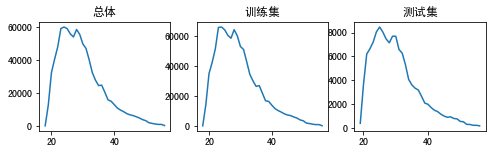

In [118]:
fig = plt.figure(figsize=(8, 2))
ax1 = fig.add_subplot(1,3,1)
plt.title('总体')
plt.plot(df_user_info_last_date.age.value_counts().sort_index())
ax2 = fig.add_subplot(1,3,2)
plt.title('训练集')
plt.plot(age_repay_train.age.value_counts().sort_index())
ax3 = fig.add_subplot(1,3,3)
plt.title('测试集')
plt.plot(age_repay_test.age.value_counts().sort_index())
plt.show() # 用户信息和训练集采样分布一致

In [119]:
# 所有用户的年龄分布
print(user_age.age.describe())

count    928195.000000
mean         29.473072
std           7.042113
min          18.000000
25%          24.000000
50%          28.000000
75%          33.000000
max          56.000000
Name: age, dtype: float64


In [120]:
# 年龄和是否还款的关系
age_repay_train['cut_age'] = pd.cut(age_repay_train.age, 10, labels=[str(x) for x in range(1, 11)]) # 将年龄切10份
age_repay_train['count'] = 1
age_repay_train = age_repay_train.groupby(['cut_age', 'is_repay'])['count'].agg(sum).reset_index()
for i in range(1, 11):
    age_repay_train.loc[age_repay_train.cut_age == str(i) ,'count'] = age_repay_train['count'] / sum(age_repay_train[age_repay_train.cut_age == str(i)]['count'])
print(age_repay_train) # 每个年龄中分布还算比较自然

   cut_age  is_repay     count
0        1         0  0.104095
1        1         1  0.895905
2        2         0  0.119104
3        2         1  0.880896
4        3         0  0.127291
5        3         1  0.872709
6        4         0  0.119494
7        4         1  0.880506
8        5         0  0.112089
9        5         1  0.887911
10       6         0  0.107835
11       6         1  0.892165
12       7         0  0.104896
13       7         1  0.895104
14       8         0  0.099992
15       8         1  0.900008
16       9         0  0.104335
17       9         1  0.895665
18      10         0  0.108077
19      10         1  0.891923


In [ ]:
# 年龄和还款间隔的关系
age_repay_train['cut_age'] = pd.cut(age_repay_train.age, 10, labels=[str(x) for x in range(1, 11)]) # 将年龄切10份
age_repay_train['count'] = 1
age_repay_train = age_repay_train.groupby(['cut_age', 'is_repay'])['count'].agg(sum).reset_index()
for i in range(1, 11):
    age_repay_train.loc[age_repay_train.cut_age == str(i) ,'count'] = age_repay_train['count'] / sum(age_repay_train[age_repay_train.cut_age == str(i)]['count'])
print(age_repay_train) # 每个年龄中分布还算比较自然

In [125]:
# 省份
print(sorted(df_user_info_train.id_province.unique())) # 身份证
print(sorted(df_user_info_train.cell_province.unique())) # 手机(有为空的)

['c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31']
['\\N', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31']


# 用户画像

In [ ]:
df_user_taglist_last_date = pd.read_csv(path_data + file_user_taglist_last_date)
with open(path_data+file_tags, 'r') as f:
    tags = json.load(f)

In [141]:
# 用户画像文件中，用户是否唯一
print(df_user_taglist.user_id.is_unique)

False


In [142]:
# 生成的最后一次用户画像中，用户是否唯一
print(df_user_taglist_last_date.user_id.is_unique)

True


In [161]:
# 标签的数量
print('tags num', len(tags))

tags num 5986


# 用户行为日志

In [164]:
# 每个行为的数量
print(df_user_behavior_logs.behavior_type.value_counts().sort_index())

1    43469932
2     1007660
3    11303679
Name: behavior_type, dtype: int64


# 用户借款日志

略

In [3]:
import pandas as pd
from config import *

a = pd.read_csv(path_data + file_user_repay_logs)
a.order_id.value_counts()

1     2768985
2     2596756
3     2441694
4     2100723
5     2020128
6     1954558
7      862387
8      836167
9      816723
12     540007
11     533457
10     529712
Name: order_id, dtype: int64

In [37]:
# 提交格式

,listing_id,repay_amt,repay_date
0,5431438,4.3309,2019-03-12
1,5431438,4.3309,2019-03-13
2,5431438,4.3309,2019-03-14
3,5431438,4.3309,2019-03-15
4,5431438,4.3309,2019-03-16
